<div style="margin-bottom: 32px;">
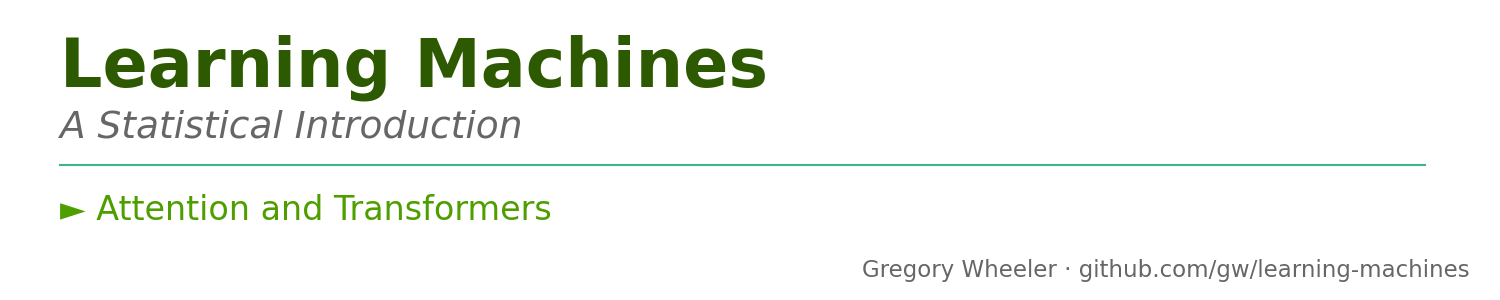
</div>


# Attention and Transformers

Attention lets a model focus on relevant parts of its input when producing each output. Transformers, built entirely from attention, have become the dominant architecture for language and increasingly for other domains. This notebook makes the core mechanism concrete: we compute attention weights by hand, visualize what the model "looks at," and build a simple self-attention layer.

**What computation adds**: Attention diagrams show connections; here we trace exact values through the computation and see how queries, keys, and values interact to produce context-aware representations.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import sys
from pathlib import Path

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# Add the notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt

# Apply the style and set notebook mode
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

np.random.seed(42)
torch.manual_seed(42)

## 1. The Problem: Context Matters

Consider the word "bank" in these sentences:
- "I deposited money at the **bank**"
- "We sat by the river **bank**"

The meaning of "bank" depends on surrounding words. A good representation should incorporate this context. **Attention** provides a mechanism for each position to gather information from other positions based on relevance.

## 2. Scaled Dot-Product Attention

The core attention computation:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- **Q** (Query): What am I looking for?
- **K** (Key): What do I contain?
- **V** (Value): What information do I provide?

The softmax produces **attention weights**—a probability distribution over positions.

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.
    
    Q: (seq_len, d_k) - queries
    K: (seq_len, d_k) - keys
    V: (seq_len, d_v) - values
    
    Returns:
        output: (seq_len, d_v) - weighted sum of values
        attention_weights: (seq_len, seq_len) - attention scores
    """
    d_k = K.shape[-1]
    
    # Step 1: Compute attention scores
    scores = Q @ K.T / np.sqrt(d_k)  # (seq_len, seq_len)
    
    # Step 2: Apply mask (optional, for causal attention)
    if mask is not None:
        scores = np.where(mask, scores, -1e9)
    
    # Step 3: Softmax to get attention weights
    attention_weights = np.exp(scores - scores.max(axis=-1, keepdims=True))
    attention_weights = attention_weights / attention_weights.sum(axis=-1, keepdims=True)
    
    # Step 4: Weighted sum of values
    output = attention_weights @ V
    
    return output, attention_weights

## 3. A Worked Example

Let's trace through attention with a tiny example: three tokens with 4-dimensional embeddings.

In [ ]:
# Three tokens: "The", "cat", "sat"
# Pretend these are learned embeddings (d=4)
embeddings = np.array([
    [1.0, 0.0, 1.0, 0.0],   # "The"
    [0.0, 1.0, 0.0, 1.0],   # "cat"
    [1.0, 1.0, 0.0, 0.0],   # "sat"
])

seq_len, d_model = embeddings.shape
tokens = ["The", "cat", "sat"]

print(f"Sequence length: {seq_len}")
print(f"Embedding dimension: {d_model}")
print(f"\nEmbeddings:")
for i, tok in enumerate(tokens):
    print(f"  {tok}: {embeddings[i]}")

In [ ]:
# In self-attention, Q, K, V are all derived from the same input
# via learned linear projections. For simplicity, we'll use identity here.
Q = embeddings.copy()  # What am I looking for?
K = embeddings.copy()  # What do I have to offer?
V = embeddings.copy()  # What information do I carry?

# Compute attention
output, attention_weights = scaled_dot_product_attention(Q, K, V)

print("Attention weights (row i attends to columns):")
print(f"         {tokens[0]:>6} {tokens[1]:>6} {tokens[2]:>6}")
for i, tok in enumerate(tokens):
    weights_str = " ".join([f"{w:6.3f}" for w in attention_weights[i]])
    print(f"{tok:>6}   {weights_str}")

In [ ]:
# Visualize attention weights
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(attention_weights, cmap='Greens', vmin=0, vmax=1)

# Labels
ax.set_xticks(range(seq_len))
ax.set_yticks(range(seq_len))
ax.set_xticklabels(tokens, fontsize=14)
ax.set_yticklabels(tokens, fontsize=14)
ax.set_xlabel('Key (attending to)', fontsize=12)
ax.set_ylabel('Query (from)', fontsize=12)

# Add text annotations
for i in range(seq_len):
    for j in range(seq_len):
        text = f'{attention_weights[i, j]:.2f}'
        color = 'white' if attention_weights[i, j] > 0.5 else 'black'
        ax.text(j, i, text, ha='center', va='center', fontsize=12, color=color)

ax.set_title('Self-Attention Weights', fontweight='bold', fontsize=14)
plt.colorbar(im, ax=ax, label='Attention Weight')
plt.tight_layout()
plt.show()

Each row shows where that token attends. In this toy example:
- "The" attends mostly to "The" and "sat" (similar embeddings)
- "cat" attends mostly to itself
- "sat" attends to all tokens more evenly

The output for each position is a weighted combination of all value vectors.

In [ ]:
print("Output (context-aware representations):")
print(f"\nOriginal embeddings → Attention output")
for i, tok in enumerate(tokens):
    orig = embeddings[i]
    new = output[i]
    print(f"{tok}: {orig} → [{new[0]:.2f}, {new[1]:.2f}, {new[2]:.2f}, {new[3]:.2f}]")

## 4. Why Scale by $\sqrt{d_k}$?

Without scaling, dot products grow with dimension, pushing softmax into regions with tiny gradients.

In [ ]:
# Demonstrate the effect of scaling
def softmax(x):
    exp_x = np.exp(x - x.max())
    return exp_x / exp_x.sum()

# Random vectors
np.random.seed(42)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

dimensions = [4, 64, 512]

for ax, d in zip(axes, dimensions):
    # Random query and key vectors
    q = np.random.randn(d)
    k = np.random.randn(d)
    
    # Dot product distribution (for many random pairs)
    n_samples = 1000
    dot_products_unscaled = []
    dot_products_scaled = []
    
    for _ in range(n_samples):
        q = np.random.randn(d)
        k = np.random.randn(d)
        dot_products_unscaled.append(q @ k)
        dot_products_scaled.append(q @ k / np.sqrt(d))
    
    ax.hist(dot_products_unscaled, bins=30, alpha=0.6, color=mt.RED, 
            label='Unscaled', density=True)
    ax.hist(dot_products_scaled, bins=30, alpha=0.6, color=mt.GREEN,
            label='Scaled', density=True)
    
    ax.set_xlabel('Dot Product')
    ax.set_ylabel('Density')
    ax.set_title(f'd = {d}', fontweight='bold')
    ax.legend()
    ax.set_xlim(-50, 50)
    
    mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

print("Scaled dot products have variance ≈ 1 regardless of dimension.")
print("This keeps softmax in a useful range.")

## 5. Multi-Head Attention

A single attention head captures one type of relationship. **Multi-head attention** runs several attention operations in parallel, then concatenates the results:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

where each head uses its own learned projections $W^Q_i, W^K_i, W^V_i$.

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention layer.
    """
    
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Linear projections for Q, K, V, and output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Project to Q, K, V
        Q = self.W_q(x)  # (batch, seq_len, d_model)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Reshape for multi-head: (batch, n_heads, seq_len, d_k)
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)
        
        # Reshape back: (batch, seq_len, d_model)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # Final linear projection
        output = self.W_o(context)
        
        return output, attention_weights

In [ ]:
# Test multi-head attention
d_model = 64
n_heads = 4
seq_len = 5

mha = MultiHeadAttention(d_model, n_heads)

# Random input sequence
x = torch.randn(1, seq_len, d_model)  # (batch=1, seq_len=5, d_model=64)

output, attn_weights = mha(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"  (batch, n_heads, seq_len, seq_len)")

In [ ]:
# Visualize attention from each head
fig, axes = plt.subplots(1, n_heads, figsize=(14, 3))

attn = attn_weights[0].detach().numpy()  # (n_heads, seq_len, seq_len)

for h, ax in enumerate(axes):
    im = ax.imshow(attn[h], cmap='Greens', vmin=0, vmax=1)
    ax.set_xlabel('Key')
    ax.set_ylabel('Query')
    ax.set_title(f'Head {h+1}', fontweight='bold')
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))

plt.suptitle('Different Heads Learn Different Attention Patterns', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Positional Encoding

Self-attention is permutation-equivariant—it treats input as a set, not a sequence. To inject position information, we add **positional encodings** to the input embeddings.

The original transformer uses sinusoidal encodings:

$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d})$$

In [ ]:
def positional_encoding(max_len, d_model):
    """
    Generate sinusoidal positional encodings.
    """
    pe = np.zeros((max_len, d_model))
    position = np.arange(max_len)[:, np.newaxis]  # (max_len, 1)
    
    # Compute the divisor term
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    
    pe[:, 0::2] = np.sin(position * div_term)  # Even indices
    pe[:, 1::2] = np.cos(position * div_term)  # Odd indices
    
    return pe

In [ ]:
# Visualize positional encodings
max_len = 50
d_model = 64
pe = positional_encoding(max_len, d_model)

fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

# Heatmap of all encodings
ax = axes[0]
im = ax.imshow(pe, cmap='RdBu', aspect='auto')
ax.set_xlabel('Dimension')
ax.set_ylabel('Position')
ax.set_title('Positional Encodings', fontweight='bold')
plt.colorbar(im, ax=ax)

# Individual dimension curves
ax = axes[1]
positions = np.arange(max_len)
for i, d in enumerate([0, 1, 2, 3, 10, 20]):
    ax.plot(positions, pe[:, d], linewidth=2, label=f'dim {d}', alpha=0.8)

ax.set_xlabel('Position')
ax.set_ylabel('Encoding Value')
ax.set_title('Positional Encoding by Dimension', fontweight='bold', loc='left')
ax.legend(loc='upper right', fontsize=9)
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Key properties:**
- Different positions have unique encodings
- Lower dimensions oscillate faster (local position)
- Higher dimensions oscillate slower (global position)
- Relative positions can be represented as linear combinations

## 7. Causal (Masked) Attention

For autoregressive models (like GPT), each position should only attend to previous positions—not future ones. We use a **causal mask**.

In [ ]:
def create_causal_mask(seq_len):
    """Create a lower-triangular mask for causal attention."""
    mask = np.tril(np.ones((seq_len, seq_len)))
    return mask.astype(bool)

seq_len = 5
causal_mask = create_causal_mask(seq_len)

# Apply causal attention
Q = np.random.randn(seq_len, 4)
K = np.random.randn(seq_len, 4)
V = np.random.randn(seq_len, 4)

_, attn_causal = scaled_dot_product_attention(Q, K, V, mask=causal_mask)
_, attn_full = scaled_dot_product_attention(Q, K, V, mask=None)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Causal mask
ax = axes[0]
ax.imshow(causal_mask, cmap='Greens')
ax.set_title('Causal Mask', fontweight='bold')
ax.set_xlabel('Key')
ax.set_ylabel('Query')
for i in range(seq_len):
    for j in range(seq_len):
        text = '1' if causal_mask[i, j] else '0'
        color = 'white' if causal_mask[i, j] else 'black'
        ax.text(j, i, text, ha='center', va='center', fontsize=14, color=color)

# Causal attention weights
ax = axes[1]
im = ax.imshow(attn_causal, cmap='Greens', vmin=0, vmax=1)
ax.set_title('Causal Attention', fontweight='bold')
ax.set_xlabel('Key')
ax.set_ylabel('Query')
for i in range(seq_len):
    for j in range(seq_len):
        text = f'{attn_causal[i, j]:.2f}'
        color = 'white' if attn_causal[i, j] > 0.5 else 'black'
        ax.text(j, i, text, ha='center', va='center', fontsize=10, color=color)

# Full attention weights
ax = axes[2]
ax.imshow(attn_full, cmap='Greens', vmin=0, vmax=1)
ax.set_title('Full Attention', fontweight='bold')
ax.set_xlabel('Key')
ax.set_ylabel('Query')
for i in range(seq_len):
    for j in range(seq_len):
        text = f'{attn_full[i, j]:.2f}'
        color = 'white' if attn_full[i, j] > 0.5 else 'black'
        ax.text(j, i, text, ha='center', va='center', fontsize=10, color=color)

plt.tight_layout()
plt.show()

With causal masking, position 3 can only attend to positions 0, 1, 2, 3—not 4. This prevents "cheating" by looking at future tokens.

## 8. A Simple Transformer Block

A transformer block combines:
1. Multi-head self-attention + residual connection + layer norm
2. Feed-forward network + residual connection + layer norm

In [ ]:
class TransformerBlock(nn.Module):
    """
    A single transformer block.
    """
    
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        
        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        
        # Feed-forward network
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Self-attention with residual
        attn_output, attn_weights = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x, attn_weights

# Test
block = TransformerBlock(d_model=64, n_heads=4, d_ff=256)
x = torch.randn(1, 10, 64)  # (batch=1, seq_len=10, d_model=64)
output, attn = block(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

## 9. Visualizing Attention in Context

Let's create a visualization showing how a query token attends to key tokens.

In [ ]:
def visualize_attention_for_token(attention_weights, tokens, query_idx, ax=None):
    """
    Visualize attention from one token to all others.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2))
    
    weights = attention_weights[query_idx]
    n_tokens = len(tokens)
    
    # Draw tokens as boxes
    for i, tok in enumerate(tokens):
        # Color intensity by attention weight
        color_intensity = weights[i]
        box_color = plt.cm.Greens(color_intensity)
        
        rect = FancyBboxPatch((i - 0.4, 0), 0.8, 0.6,
                              boxstyle='round,pad=0.05',
                              facecolor=box_color,
                              edgecolor='black' if i == query_idx else 'gray',
                              linewidth=3 if i == query_idx else 1)
        ax.add_patch(rect)
        
        # Token text
        text_color = 'white' if color_intensity > 0.5 else 'black'
        ax.text(i, 0.3, tok, ha='center', va='center', fontsize=12,
               fontweight='bold' if i == query_idx else 'normal', color=text_color)
        
        # Weight annotation
        ax.text(i, -0.2, f'{weights[i]:.2f}', ha='center', va='top', fontsize=10,
               color=mt.GREEN)
    
    ax.set_xlim(-0.6, n_tokens - 0.4)
    ax.set_ylim(-0.5, 1)
    ax.axis('off')
    ax.set_title(f'Attention from "{tokens[query_idx]}"', fontweight='bold', fontsize=14)
    
    return ax

In [ ]:
# Example sentence
tokens = ["The", "quick", "brown", "fox", "jumps"]
n = len(tokens)

# Create embeddings and compute attention
np.random.seed(123)
embeddings = np.random.randn(n, 8)
# Make "fox" similar to "quick" and "jumps" to emphasize relationships
embeddings[3] = embeddings[1] * 0.8 + np.random.randn(8) * 0.2

_, attn = scaled_dot_product_attention(embeddings, embeddings, embeddings)

fig, axes = plt.subplots(n, 1, figsize=(10, 8))

for i, ax in enumerate(axes):
    visualize_attention_for_token(attn, tokens, i, ax)

plt.tight_layout()
plt.show()

Each token attends differently. In trained models, these patterns become meaningful—subjects attend to verbs, pronouns attend to their referents, etc.

---

## Summary

**Attention mechanism:**
- Queries, keys, and values interact via dot products
- Softmax produces attention weights (where to focus)
- Output is weighted sum of values

**Multi-head attention:**
- Multiple attention heads capture different relationships
- Heads are concatenated and projected

**Positional encoding:**
- Injects position information (attention is position-agnostic)
- Sinusoidal encodings: different frequencies for different dimensions

**Causal masking:**
- Prevents attending to future positions
- Essential for autoregressive generation

**Transformer block:**
- Attention + residual + norm
- Feed-forward + residual + norm
- Stack many blocks for deep transformers

---

**Computational note:**

Standard attention has **O(n²)** complexity in sequence length n, since every token attends to every other token. For a sequence of 1000 tokens, this means ~1 million attention computations per layer.

This quadratic scaling motivated research into efficient attention variants:
- **Sparse attention**: Only attend to nearby tokens plus selected distant ones
- **Linear attention**: Approximate softmax attention with O(n) complexity
- **Flash attention**: Hardware-aware implementation that's faster without approximation

For most applications with moderate sequence lengths (<4096), standard attention works well.

## Exploration

Try modifying:
- **Number of heads**: How do attention patterns change with 1 head vs 8 heads?
- **Sequence length**: What happens to attention with very long sequences?
- **Pre-trained models**: Use Hugging Face transformers to visualize attention in real language models